<a href="https://colab.research.google.com/github/dd-open-source/ml-projects/blob/main/transfer_learning/Emergency_Or_Not/Emergency_vehicle_Image_Classification_using_transfer_learning_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our solution for [Analytics Vidhya Hackathon](https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon) using image generator and flow_from_dataframe

In [1]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import files

### Defines reusable constants

In [3]:
# Data files: 
# Google drive: https://drive.google.com/file/d/1jnhIjWUL7B4K4iJ665f7JgWbODmGAMAn/view
# Download the above data files from our google drive 
# to your google drive or local computer and update the below paths accordingly

project_folder = '/content/drive/MyDrive/ML_Projects/Emergency_Or_Not'
data_dir = path.join(project_folder, 'data')
models_path =path.join(project_folder, 'models')
models_dir = path.join(models_path, "base")
train_csv_path = path.join(data_dir, 'train.csv')
test_csv_path = path.join(data_dir, 'test.csv')
label_col = 'emergency_or_not'
image_idx_col = 'image_idx'
image_names_col = 'image_names'
images_dir = path.join(data_dir, "images")
imgy = imgx = 224
submission_csv_path = path.join(data_dir, 'submission.csv')

Define common functions

In [13]:
from keras_preprocessing.image import dataframe_iterator
def get_image_id(img_name):
    return int(img_name[:-4])

def get_image(img_name):
    img_path = path.join(images_dir, img_name)
    return Image.open(img_path)

# Shows a randomly selected images from data
def showImages(df, n=1):
    cols = 5
    rows = max(1, n//cols)
    sample = df.sample(n=n).reset_index(drop=True)
    for idx, row in sample.iterrows():
      img = get_image(row[image_names_col])
      plt.subplot(rows, cols, idx+1)
      plt.title(row[label_col])
      plt.imshow(img)
    plt.figure(figsize=(10, 20))
    plt.show()

# Creates tensorflow data generator for images
def create_image_generator(df, shuffle=False, class_mode="binary", batch_size=32):
    image_gen = ImageDataGenerator()
    dataframe_iterator = image_gen.flow_from_dataframe(df, images_dir, x_col=image_names_col, y_col=label_col, batch_size=batch_size,
                                       class_mode=class_mode, shuffle=shuffle, target_size=(imgy, imgx), validate_filenames=False)

    return dataframe_iterator

### Load data

In [5]:
train_df = pd.read_csv(train_csv_path)
train_df[label_col] = np.where(train_df[label_col]==0, "No", "Yes")
test_df = pd.read_csv(test_csv_path)


### Prepare datasets for training and validation

In [15]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
train_gen = create_image_generator(train_data, shuffle=True)
val_gen = create_image_generator(val_data)
test_gen = create_image_generator(test_df, class_mode=None)

Found 1316 non-validated image filenames belonging to 2 classes.
Found 330 non-validated image filenames belonging to 2 classes.
Found 706 non-validated image filenames.


### Training deep neaural network using Tensorflow

**Transfer learning**: We are using ResNet model for image classification.
1. In 1st phase, we train our model by freezing keeping pre_trained_model (i.e setting trainable=False)
1. In 2nd phase, we train our model by unfreezing keeping pre_trained_model (i.e setting trainable=True) but with very small learning_rate

In [16]:
def create_model(trainable=False):
    pre_trained_model = resnet_v2.ResNet50V2(include_top=False, pooling='max', weights='imagenet', input_shape=(imgy, imgx, 3))
    input = tf.keras.Input(shape=(imgy, imgx, 3))
    output = resnet_v2.preprocess_input(input)
    output = pre_trained_model(output, training=False)
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(1, activation="sigmoid")(output)
    pre_trained_model.trainable=trainable
    model = tf.keras.Model(input, output)
    return model

def compile_and_fit(model, train_gen, val_gen, model_path, learning_rate, epochs=5, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=patience,
                                                     mode='min', min_delta=0.0001, cooldown=0, 
                                                     min_lr=min(0.0001, learning_rate))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                                                   mode='min', save_weights_only=True,
                                                                   save_best_only=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model.fit(train_gen, epochs=epochs, validation_data=val_gen,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])


Fast learning phase by freezing the pre-trained-model

In [18]:
model = create_model()
print(model.summary())
model_path = path.join(models_dir, "best")
model.load_weights(tf.train.latest_checkpoint(models_dir))
compile_and_fit(model, train_gen, val_gen, model_path, learning_rate=0.01, epochs=10, patience=3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049

Slow learning phase by unfreezing the pre-trained model

In [23]:
# Create best model from saved weights
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
model = create_model(trainable=True)
model.set_weights(best_model.get_weights())
compile_and_fit(model, train_gen, val_gen, model_path, learning_rate=1e-5, epochs=10, patience=3)

Epoch 1/10
42/42 [==============================] - 17s 261ms/step - loss: 0.0896 - accuracy: 0.9901 - val_loss: 0.0980 - val_accuracy: 0.9939 - lr: 1.0000e-05
Epoch 2/10
42/42 [==============================] - 10s 238ms/step - loss: 0.1267 - accuracy: 0.9863 - val_loss: 0.0248 - val_accuracy: 0.9939 - lr: 1.0000e-05
Epoch 3/10
42/42 [==============================] - 10s 246ms/step - loss: 0.0382 - accuracy: 0.9932 - val_loss: 0.0217 - val_accuracy: 0.9909 - lr: 1.0000e-05
Epoch 4/10
42/42 [==============================] - 9s 212ms/step - loss: 0.0865 - accuracy: 0.9878 - val_loss: 0.0795 - val_accuracy: 0.9879 - lr: 1.0000e-05
Epoch 5/10
42/42 [==============================] - 9s 215ms/step - loss: 0.0767 - accuracy: 0.9894 - val_loss: 0.0637 - val_accuracy: 0.9909 - lr: 1.0000e-05
Epoch 6/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0252 - accuracy: 0.9954 - val_loss: 0.0405 - val_accuracy: 0.9939 - lr: 1.0000e-05


#### Check results on test dataset

In [24]:
# Create best model from saved weights
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
test_predictions = best_model.predict(test_gen)
test_df[label_col] = (test_predictions>0.5).astype(np.uint0)

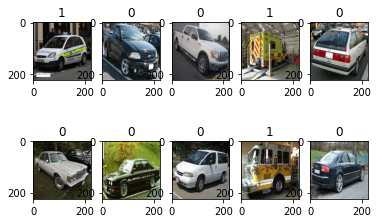

<Figure size 720x1440 with 0 Axes>

In [25]:
showImages(test_df, n=10)

**Create Submission file**

In [26]:
test_df[[image_names_col, label_col]].to_csv(submission_csv_path, index=False)
files.download(submission_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>